# Topics as Map or Index

After loading the data, we are going to run the SciKit-Learn's NMF algorithm which is both fast for smaller corpora and deterministic in its outcomes varying the number of components until we seem to have achieved a stable number.

We are including both main and other TED-curated events here so that we can see how much the separate events are part of the larger map or if they are distinct.

As topic modelling has become more widespread, one of the issues increasingly being raised is right-sizing the number of components, since that is something that is principal variable given to the algorithm (be it LDA or NMF). The implementation that follows is based on the following:

* In an article in _Towards Data Science_, [Evaluate Topic Models: Latent Dirichlet Allocation][kapadia], Shashank Kapadia observes that most evaluations of enumerated topics are extrinsic in nature, a product of subject matter expertise and/or utility in performing a classification task. His approach is to implement an intrinsic evaluation using **gensim**'s `CoherenceModel`. He then fine tunes the hyperparameters. 
* The third notebook in Derek Greene's three-notebook tutorial on NMF focuses on [Parameter Selection][greene]. One of the hyperparameters involved has to do with initialization: Greene notes that "using SVD-based initialisation provides more reliable results." 

Greene's work is the foundation for the following exploration.

[kapadia]: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
[greene]: https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb

## Imports and Data

In [1]:
# Imports #
import pandas as pd
import re
import numpy as np
from sklearn.externals import joblib
from sklearn.decomposition import NMF

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 14})

ImportError: cannot import name 'joblib' from 'sklearn.externals' (/opt/anaconda3/lib/python3.8/site-packages/sklearn/externals/__init__.py)

In [2]:
(tfidf, terms, talks) = joblib.load( "talks-tfidf.pkl" )
print( f"Loaded {tfidf.shape[0]} X {tfidf.shape[1]} document-term matrix.")

Loaded 1747 X 29197 document-term matrix.


In [10]:
df = pd.read_csv('../output/TEDall.csv')

# Having the talks is handy for cross-checking work:
talks = df.text.tolist()
# Create some labels we can use later but remove the redundant parts of the URL:
labels = [re.sub('https://www.ted.com/talks/', '',item) for item in df.public_url.tolist()]

## NMF

Following our exploration of the appropriate number of topics for this corpus, we will attempt a rough first pass at topic modeling the TED talk corpus. Since early experiments suggested that ~50 topics might be appropriate, we will start there.

NMF produces two factor matrices as its output: **W** and **H**. 

The **W** factor contains the document membership weights relative to each of the k topics. Each row corresponds to a single document, and each column correspond to a topic.

The **H** factor contains the term weights relative to each of the k topics. In this case, each row corresponds to a topic, and each column corresponds to a unique term in the corpus vocabulary.

So our 1747 X 29197 term matrix is broken down into two matrices, one 1747 x 50 and the other 50 x 29197.)

In [7]:
k = 50
model = NMF( init="nndsvd", n_components= k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform( tfidf )
H = model.components_

In [8]:
W.shape, H.shape

((1747, 50), (50, 29197))

In [24]:
# It looks like terms is something we get for free with NMF
# joblib.dump((W,H,terms,talks), f"../output/test-model-nmf-k{k}.pkl")

['../output/test-model-nmf-k50.pkl']

## Exploration

In [12]:
talks[0][0:200]

"  Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful. I have been blown away by this conference, and I want to thank all"

In [31]:
# Topic weights for first document rounded to 2 decimal places for display purposes
W[0,:].round(2)

array([0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.07, 0.03, 0.  ,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.02, 0.  , 0.  , 0.03, 0.01, 0.  , 0.  , 0.03, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.01, 0.  , 0.  ])

I'm still working on understanding array slicing versus list slicing: `[0,:]` is Row 0 and all the columns. A simple list slice -- `W[0].round(2)` -- produces the same results. However, to see all the documents associated with a particular topic, we want all the rows for a given column:

In [32]:
W[:,0].round(2)

array([0.01, 0.01, 0.  , ..., 0.  , 0.  , 0.  ])

We can likewise see which topics a term is most associated. (The talk above is Al Gore's on climate change so seeing that the term climate is most associated with a topic strongly related to Gore's talk confirms that things are working reasonably well.)

In [13]:
term_index = terms.index('climate')
# round to 2 decimal places for display purposes
H[:,term_index].round(2)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 2.35, 0.  , 0.05,
       0.  , 0.07, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

## Descriptors (Topic Word Clusters)

In [14]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [19]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 8 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print(f"Topic {topic_index+1:2d}: {str_descriptor}" )

Topic  1: going, know, really, things, think, people, get, actually
Topic  2: music, guitar, ends, classical, play, orchestra, violin, musical
Topic  3: said, would, know, life, man, never, day, love
Topic  4: china, growth, chinese, economic, countries, india, democracy, world
Topic  5: cells, stem, cell, tissue, bone, actually, body, disease
Topic  6: planets, earth, planet, mars, stars, telescope, star, solar
Topic  7: god, religious, religion, faith, religions, world, compassion, church
Topic  8: building, architecture, buildings, space, architects, city, built, spaces
Topic  9: brain, neurons, brains, cortex, going, see, neuroscience, body
Topic 10: women, men, woman, pm, gender, equality, feminist, male
Topic 11: africa, african, continent, africans, countries, nigeria, south, aid
Topic 12: robot, robots, locomotion, robotics, rules, move, see, legs
Topic 13: patients, health, medical, patient, doctors, care, doctor, medicine
Topic 14: internet, information, media, online, govern

Greene notes that it would be nice to see the weights for each term in a descriptor. 

In [20]:
def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

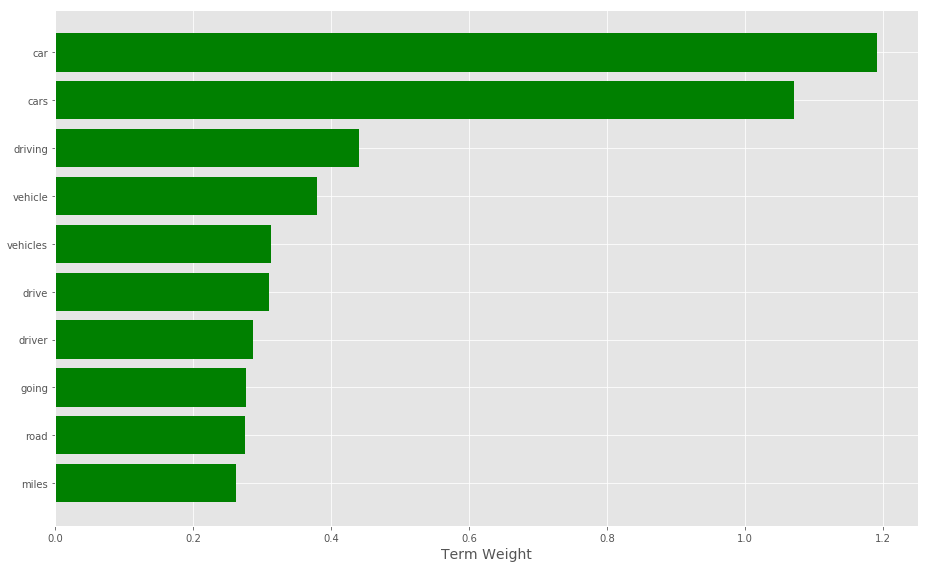

In [21]:
plot_top_term_weights( terms, H, 20, 10 )

And which documents are most associated with a given topic:

In [22]:
def get_top_docs( documents, W, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_docs = []
    for doc_index in top_indices[0:top]:
        top_docs.append( documents[doc_index] )
    return top_docs

In [23]:
topic_documents = get_top_docs( talks, W, 20, 5 )
for i, talk in enumerate(topic_documents):
    print(f"{i+1}: {talk[0:20]}")
#     print(f"{i+1}: {labels[i]}") # See note below 

1:   So in 1885, Karl B
2:   So how would you r
3:   By birth and by ch
4:   As a boy, I loved 
5:   Today I wanted to 


Eventually will want this to list the talk: 

    1: al_gore_on_averting_climate_crisis